In [ ]:
# Monta o Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importações necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, BatchNormalization, Activation, LeakyReLU, Cropping2D
)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, MeanIoU
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# 1- Importando os dados de treino e teste já processados

In [ ]:
# Caminho para o arquivo HDF5 no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

X_train = []
X_test = []
y_train = []
y_test = []

# Abrindo o arquivo e lendo os datasets
with h5py.File(file_path, 'r') as h5f:
    X_train = h5f['x_train'][:]
    X_test = h5f['x_test'][:]
    y_train = h5f['y_train'][:]
    y_test = h5f['y_test'][:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9570, 128, 128, 3),
 (798, 128, 128, 3),
 (9570, 128, 128, 3),
 (798, 128, 128, 3))

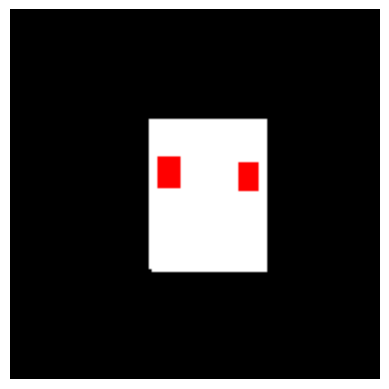

In [ ]:
plt.imshow(y_test[0], cmap='gray')
plt.axis('off')
plt.show()

# 2- Processamento das mascaras

In [ ]:
def preprocess_y(y):

    black = [0, 0, 0]
    white = [255, 255, 255]
    red = [255, 0, 0]

    mask_black = np.all(y == black, axis=-1)
    mask_white = np.all(y == white, axis=-1)
    mask_red = np.all(y == red, axis=-1)

    y_processed = np.stack([mask_black, mask_white, mask_red], axis=-1).astype(np.float32)

    return y_processed

In [ ]:
y_train = preprocess_y(y_train)
y_test = preprocess_y(y_test)

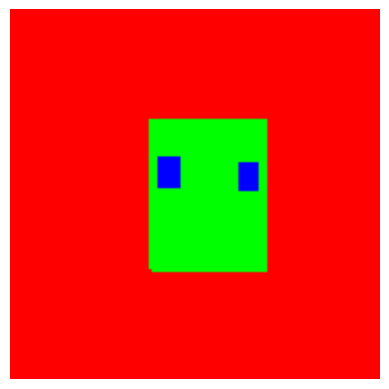

In [ ]:
plt.imshow(y_test[0], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

assert np.allclose(np.sum(y_train, axis=-1), 1.0)
assert np.allclose(np.sum(y_test, axis=-1), 1.0)

y_train_processed = tf.convert_to_tensor(y_train)
y_test_processed = tf.convert_to_tensor(y_test)

Forma de y_train: (9570, 128, 128, 3)
Forma de y_test: (798, 128, 128, 3)


# 3- Nova divisão em conjunto de treino e teste

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training and validation with the same preprocessing
datagen = ImageDataGenerator(
    validation_split=0.2  # Setting the validation split
)

# Generate training data
train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset='training'  # Set as training data
)

# Generate validation data
val_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,
    subset='validation'  # Set as validation data
)


In [ ]:
# 4- Função de loss

In [ ]:
def three_class_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        class_weights = 1.0 / (K.sum(K.sum(y_true, axis=[1, 2]), axis=0) + epsilon)
        class_weights = class_weights / K.sum(class_weights)
        class_weights = K.expand_dims(K.expand_dims(K.expand_dims(class_weights, axis=0), axis=0), axis=0)

        ce_loss = categorical_crossentropy(y_true, y_pred)
        pt = K.sum(y_true * y_pred, axis=-1)
        focal_loss = alpha * K.pow(1. - pt, gamma) * ce_loss

        weighted_focal_loss = K.sum(class_weights * y_true, axis=-1) * focal_loss

        return K.mean(weighted_focal_loss)
    return loss

# 5- Criação do modelo

In [ ]:
def ModelEnhancer():
    input_shape = (128, 128, 3)
    VGG16_weight = vgg_model.get_weights()
    vgg_base = VGG16(include_top=False, weights=None, input_shape=input_shape)
    vgg_base.set_weights(VGG16_weight)
    last_layer = vgg_base.output

    set_trainable = False
    for layer in vgg_base.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']:
            layer.trainable = False

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(last_layer)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block5_output = vgg_base.get_layer("block5_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block5_output)[1:3]:
        block5_output = Cropping2D(cropping=((1, 1), (1, 1)))(block5_output)
    concat_1 = concatenate([model_, block5_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_1)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block4_output = vgg_base.get_layer("block4_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block4_output)[1:3]:
        block4_output = Cropping2D(cropping=((1, 1), (1, 1)))(block4_output)
    concat_2 = concatenate([model_, block4_output])

    model_ = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(concat_2)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block3_output = vgg_base.get_layer("block3_conv3").output
    if K.int_shape(model_)[1:3] != K.int_shape(block3_output)[1:3]:
        block3_output = Cropping2D(cropping=((1, 1), (1, 1)))(block3_output)
    concat_3 = concatenate([model_, block3_output])

    model_ = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(concat_3)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block2_output = vgg_base.get_layer("block2_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block2_output)[1:3]:
        block2_output = Cropping2D(cropping=((1, 1), (1, 1)))(block2_output)
    concat_4 = concatenate([model_, block2_output])

    model_ = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(concat_4)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    block1_output = vgg_base.get_layer("block1_conv2").output
    if K.int_shape(model_)[1:3] != K.int_shape(block1_output)[1:3]:
        block1_output = Cropping2D(cropping=((1, 1), (1, 1)))(block1_output)
    concat_5 = concatenate([model_, block1_output])

    model_ = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(concat_5)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (3, 3), strides=(1, 1), padding='same')(model_)
    model_ = LeakyReLU(0.1)(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(3, (1, 1), activation='softmax', padding='same')(model_)

    model_ = Model(vgg_base.input, model_)

    return model_

In [ ]:
model = ModelEnhancer()
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=three_class_focal_loss(),
              metrics=[CategoricalAccuracy(), MeanIoU(num_classes=3)])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_three_class_model.keras', save_best_only=True, monitor='val_mean_io_u')

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/6
240/240 [==============================] - 52s 119ms/step - loss: 0.0028 - categorical_accuracy: 0.6324 - mean_io_u: 0.3333 - val_loss: 0.0032 - val_categorical_accuracy: 0.7461 - val_mean_io_u: 0.3333 - lr: 1.0000e-04
Epoch 2/6
240/240 [==============================] - 20s 85ms/step - loss: 0.0020 - categorical_accuracy: 0.7435 - mean_io_u: 0.3333 - val_loss: 0.0019 - val_categorical_accuracy: 0.7850 - val_mean_io_u: 0.3333 - lr: 1.0000e-04
Epoch 3/6
240/240 [==============================] - 20s 85ms/step - loss: 0.0018 - categorical_accuracy: 0.7647 - mean_io_u: 0.3333 - val_loss: 0.0018 - val_categorical_accuracy: 0.7778 - val_mean_io_u: 0.3333 - lr: 1.0000e-04
Epoch 4/6
240/240 [==============================] - 20s 85ms/step - loss: 0.0017 - categorical_accuracy: 0.7779 - mean_io_u: 0.3333 - val_loss: 0.0017 - val_categorical_accuracy: 0.7601 - val_mean_io_u: 0.3333 - lr: 1.0000e-04
Epoch 5/6
240/240 [==============================] - 20s 84ms/step - loss: 0.0015 - cat

# 6- Resultados

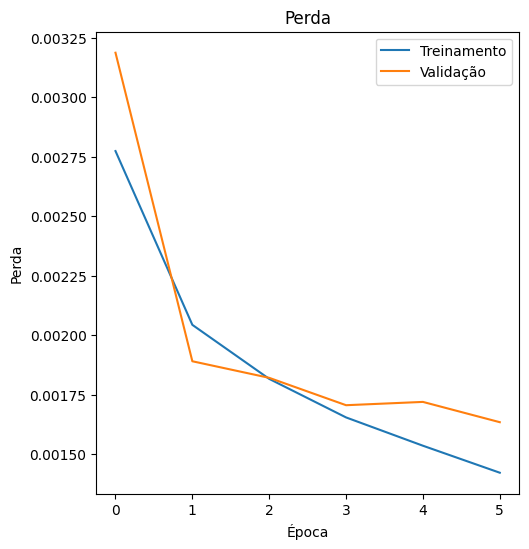

In [ ]:
history_dict = history.history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

25/25 [==============================] - 3s 126ms/step


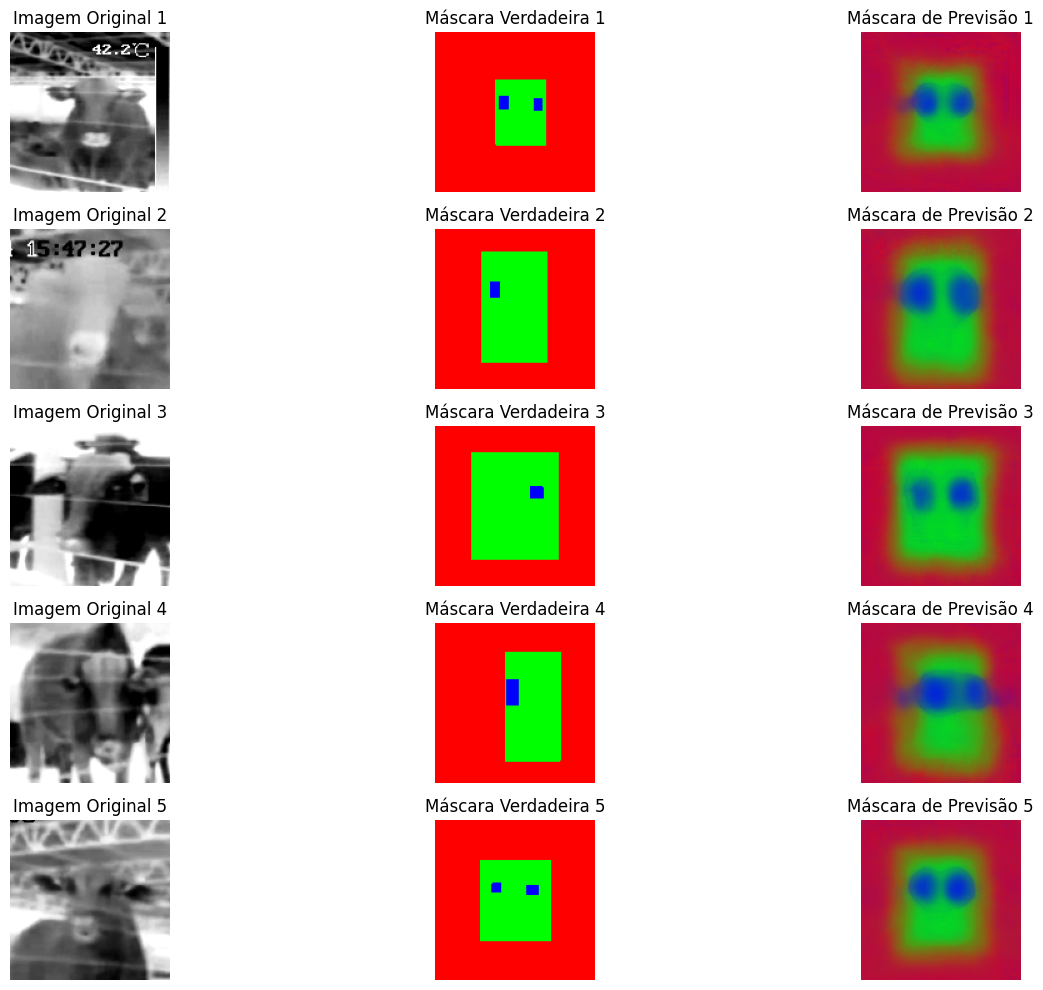

In [ ]:
predictions = model.predict(X_test)

num_images_to_show = 5

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(num_images_to_show, 3, i * 3 + 1)
    plt.title(f"Imagem Original {i+1}")
    plt.imshow(X_test[i].reshape(X_test.shape[1:]), cmap='gray')
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 2)
    plt.title(f"Máscara Verdadeira {i+1}")
    plt.imshow(y_test[i].reshape(y_test.shape[1:]), cmap='gray')
    plt.axis('off')

    plt.subplot(num_images_to_show, 3, i * 3 + 3)
    plt.title(f"Máscara de Previsão {i+1}")
    plt.imshow(predictions[i].reshape(predictions.shape[1:]), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

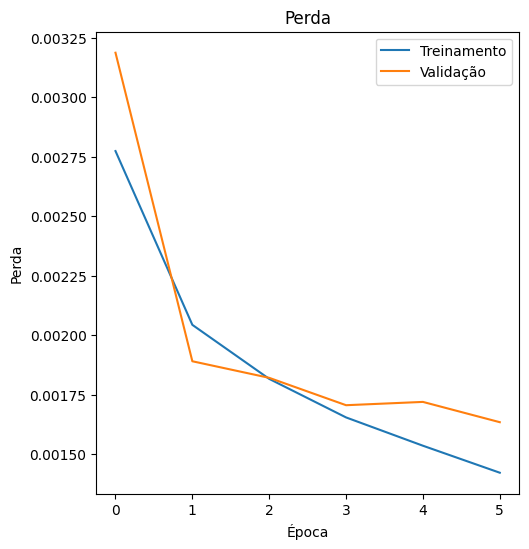

In [ ]:
history_dict = history.history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Treinamento')
plt.plot(history_dict['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

In [ ]:
# Caminho completo onde o arquivo será salvo
save_path = '/content/drive/MyDrive/PROJETO/g5_vgg16_transferlearning_28_ago.h5'

# Salvar o modelo no caminho especificado
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
